# Validation

In [41]:
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import os
import descriptors
import numpy as np

pathModel="vaeModeltrained"

dict_r = np.load('data_dict_jerem_v1.npy', allow_pickle=True).item()
train_db = np.zeros([len(dict_r['env']),2,750])

i = 0
for sample in dict_r['env']:
    train_db[i,:,:] = sample
    i+=1

train_db[:,1,:] = np.log10(train_db[:,1,:])
pitches = np.mean(train_db[:,1,:], axis=1)
pitches = np.expand_dims(pitches, axis=1)
pitches = np.broadcast_to(pitches,(218,750))

train_db[:,1,:] = train_db[:,1,:]-pitches[:] #on retire le pitch

MAX1 = np.max(train_db[:,0,:])
MAX2 = np.max(train_db[:,1,:])
train_db[:,0,:] /= MAX1
train_db[:,1,:] /= MAX2



In [44]:
np.min(train_db[:,1,:])

-0.8552195575269196

In [12]:
###### Espace latent 2 dimensions

latent_dims = 64
num_epochs = 3000
batch_size = 25
capacity = 2
learning_rate = 5e-4
variational_beta = 5e-3
coefPitch=10.
coefLoudness=1.

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity     
        self.conv1 = nn.Sequential(nn.Conv1d(in_channels=2, out_channels=c, kernel_size=10, stride=2, padding=2), nn.BatchNorm1d(c)) # out: c, 372
        self.conv2 = nn.Sequential(nn.Conv1d(in_channels=c, out_channels=c*2, kernel_size=5, stride=2, padding=2), nn.BatchNorm1d(2*c)) # out: c*2, 186
        self.conv3 = nn.Sequential(nn.Conv1d(in_channels=c*2, out_channels=c*4, kernel_size=5, stride=2, padding=2), nn.BatchNorm1d(4*c)) # out: c*2, 186
        self.conv4 = nn.Sequential(nn.Conv1d(in_channels=c*4, out_channels=c*8, kernel_size=5, stride=2, padding=2), nn.BatchNorm1d(8*c)) # out: c*2, 186
        self.conv5 = nn.Sequential(nn.Conv1d(in_channels=c*8, out_channels=c*8, kernel_size=5, stride=1, padding=2), nn.BatchNorm1d(8*c)) # out: c*2, 186
        self.lin1 = nn.Linear(8*c*47, latent_dims*8)
        self.lin2 = nn.Linear(latent_dims*8, latent_dims*4)
        self.fc_mu = nn.Linear(in_features=latent_dims*4, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=latent_dims*4, out_features=latent_dims)
       
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=latent_dims*4)
        self.lin2 = nn.Linear(latent_dims*4, latent_dims*8)
        self.lin3 = nn.Linear(latent_dims*8, 8*c*47)
        self.lin4 = nn.Linear(in_features=750, out_features=750)
        self.conv1 = nn.Sequential(nn.Conv1d(in_channels=c*8, out_channels=c*8, kernel_size=5, stride=1, padding=2), nn.BatchNorm1d(8*c))
        self.conv2 = nn.Sequential(nn.Conv1d(in_channels=c*8, out_channels=c*4, kernel_size=5, stride=1, padding=2), nn.BatchNorm1d(4*c)) # out: c*2, 186
        self.conv3 = nn.Sequential(nn.Conv1d(in_channels=c*4, out_channels=c*2, kernel_size=5, stride=1, padding=2), nn.BatchNorm1d(2*c)) # out: c*2, 186
        self.conv4 = nn.Sequential(nn.Conv1d(in_channels=c*2, out_channels=c, kernel_size=5, stride=1, padding=2), nn.BatchNorm1d(c)) # out: c*2, 186
        self.conv5 = nn.Sequential(nn.Conv1d(in_channels=c, out_channels=2, kernel_size=10, stride=1, padding=4)) # out: c, 372
        self.conv6 = nn.Sequential(nn.Conv1d(in_channels=2, out_channels=2, kernel_size=10, stride=1, padding=4)) # out: c, 372
        self.upsample1 = nn.Upsample(scale_factor=2, mode="nearest")
        self.upsamplef = nn.Upsample(size=752, mode="nearest")

            
    def forward(self, x):
        x = F.relu(self.fc(x))
        x = F.relu(self.lin2(x))
        x = F.relu(self.lin3(x))
        x = x.view(x.size(0), capacity*8, 47) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv1(x))
        x = self.upsample1(x)
        x = F.relu(self.conv2(x))
        x = self.upsample1(x)
        x = F.relu(self.conv3(x))
        x = self.upsample1(x)
        x = F.relu(self.conv4(x))
        x = self.upsamplef(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = torch.sigmoid(self.lin4(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x
        
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = (coefLoudness*F.mse_loss(recon_x[:,0,:], x[:,0,:], reduction='sum')+coefPitch*F.mse_loss(recon_x[:,1,:], x[:,1,:], reduction='sum'))/np.size(batch_size)
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())/np.size(batch_size)  
    return recon_loss + variational_beta * kldivergence, recon_loss, variational_beta * kldivergence
    
vae = VariationalAutoencoder()

In [13]:
vae.load_state_dict(torch.load(pathModel))

<All keys matched successfully>

In [19]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# En entrée, l'image à reconstruire et le modèle utilisé pour la reconstruction

index_list = [10,20,30,40,50,60]
index_list = list(range(12))

list_sources = [[train_db[i,0,:],train_db[i,1,:]] for i in index_list]

list_images = []
for i in index_list:
    images = train_db[i,:,:]
    images_recon,_,_ = vae(torch.from_numpy(images).view(1,2,750).float())
    images_recon = images_recon.detach().numpy()
    list_images.append([images_recon[0,0,:],images_recon[0,1,:]])


In [20]:
from visualizer import Visualizer
V = Visualizer(list_images,list_sources) 

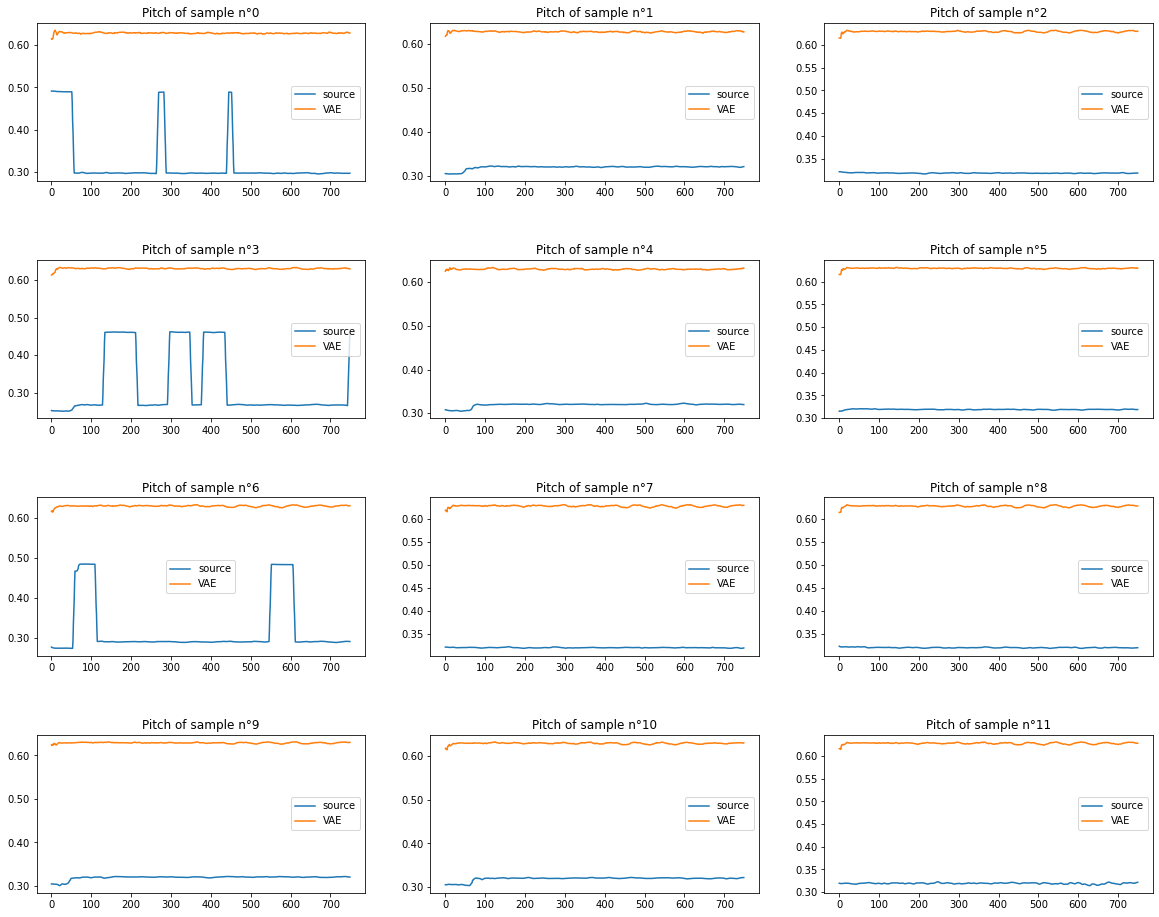

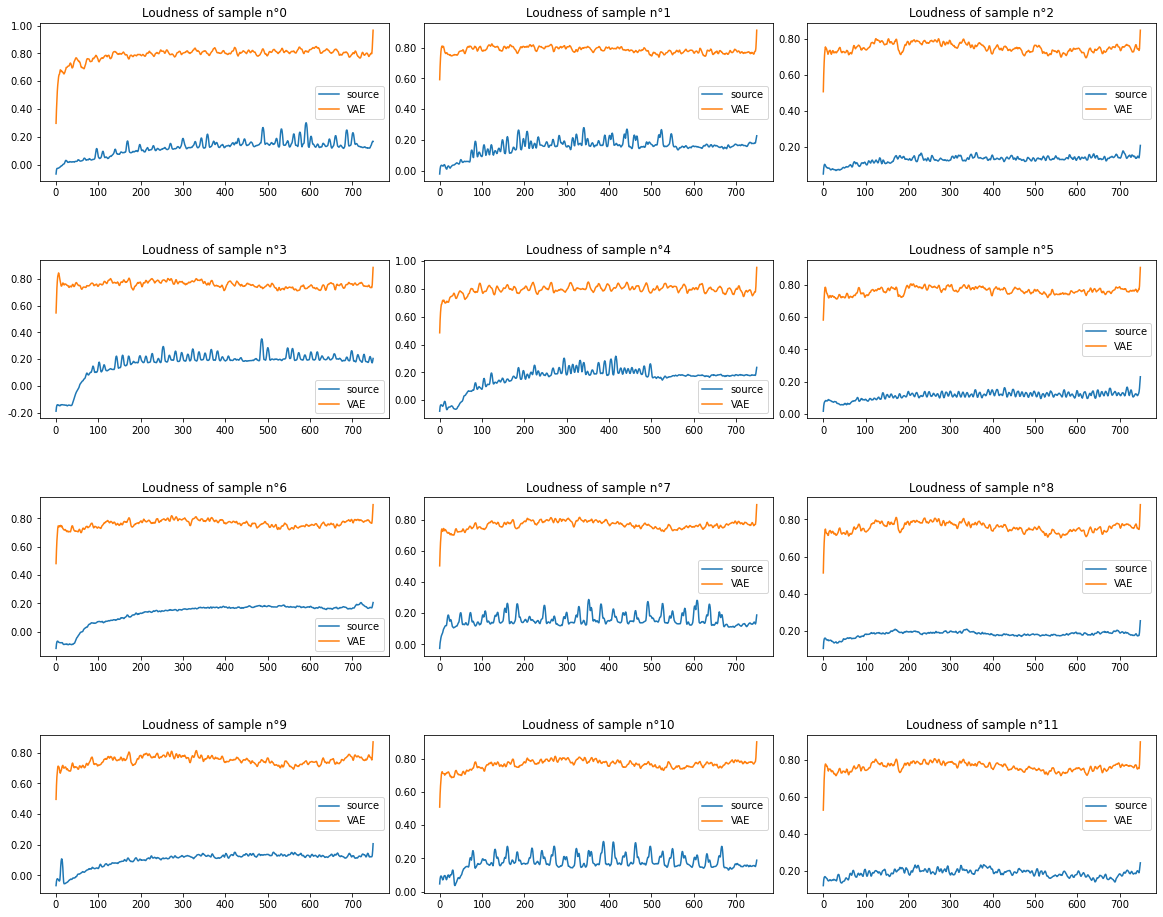

In [21]:
V.show_pitch()
V.show_loudness()

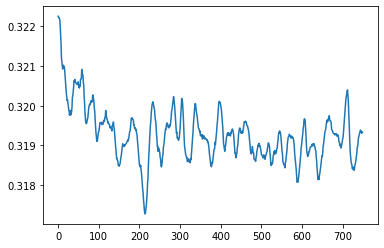

In [23]:
fig=plt.figure()
test=train_db[2,1,:]
plt.plot(test)

In [24]:
fig=plt.figure()
recons=vae(torch.from_numpy(train_db[2,:,:]).view(1,2,750).float())
#plt.plot(recons.detach().numpy())

<Figure size 432x288 with 0 Axes>

In [40]:
test=recons[2,0,:]
#plt.plot(recons[2].detach())

TypeError: tuple indices must be integers or slices, not tuple

In [39]:
test.shape

torch.Size([1, 64])

In [37]:
train_db[2,:,:].shape

(2, 750)